In [1]:
import scipy.io as sio
GOOGLE_COLAB = True
if GOOGLE_COLAB:
    from google.colab import drive, files
    drive.mount('/content/drive')
    data_path = "/content/drive/My Drive/BanglaHandwrittenDigit/"

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.layers import (Dropout, Input, Dense, Conv2D, 
                          MaxPooling2D, GlobalAveragePooling2D, 
                          UpSampling2D, Conv2DTranspose, 
                          Reshape, Flatten, Activation, 
                          BatchNormalization)
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
import cv2
from tqdm import tqdm
import random
import os
np.random.seed(10)

In [3]:
DATA_DIR = data_path
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
VALID_DATA_DIR = os.path.join(DATA_DIR, 'validation')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test')

In [4]:
IMG_SIZE = 28
CATEGORIES = ['0','1','2','3','4','5','6','7','8','9']
   
print(CATEGORIES)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [5]:
width, height, channel = 28, 28, 3

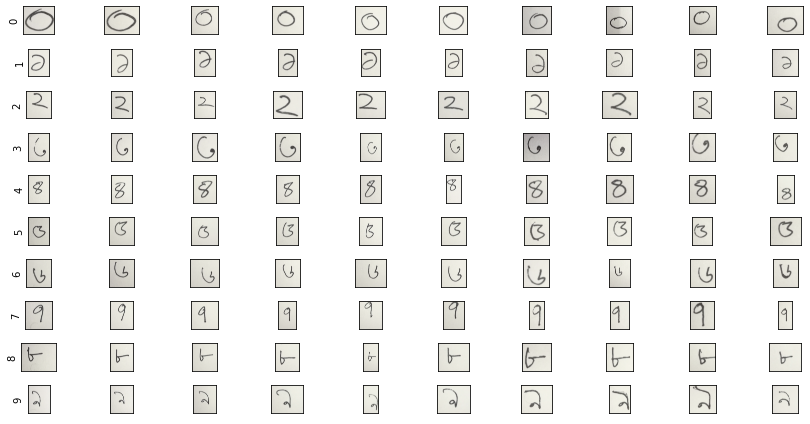

In [6]:
plt.figure(figsize=(12,6))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(10,10,i+1)
        plt.imshow(img_array)
        if i%10 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%10 == 0:
            break

plt.tight_layout()        
plt.show()

In [7]:
X = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) 
            X.append([img_resized, class_num]) 
        except WException as e:
            pass
        
print(len(X))

100%|██████████| 14/14 [00:01<00:00, 10.73it/s]

140


In [8]:
random.shuffle(X)

In [9]:
X_train = []
Y_train = []
# X_train.shape
for img, label in X:
    X_train.append(img)
    Y_train.append(label)
    
X_train = np.array(X_train).astype('float32').reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (140, 28, 28, 3) Y_train= (140,)


In [10]:
X_train = (X_train - 127.5) / 127.5

In [11]:
gen_optimizer = Adam(0.0001, 0.5)
disc_optimizer = Adam(0.0002, 0.5)
noise_dim = 100

In [17]:
def buildGenerator():
    model = Sequential()

    model.add(Dense(1024, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # model.add(Dense(2048, input_dim=noise_dim))
    # model.add(BatchNormalization(momentum=0.8))
    # model.add(Activation("relu"))
    
    model.add(Dense(6272, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Reshape((7, 7, 128)))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (2, 2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))

    # model.add(UpSampling2D((2, 2)))
    # model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    # model.add(BatchNormalization(momentum=0.8))
    # model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(3, (3, 3), padding='same', activation = "tanh", kernel_initializer=RandomNormal(0, 0.02)))
    
    return model

In [18]:
generator = buildGenerator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              103424    
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 6272)              6428800   
                                                                 
 batch_normalization_5 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 6272)             

In [19]:
def buildDiscriminator():
    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(28, 28, 3)))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, (5, 5), strides=2, kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=disc_optimizer)
    return model

In [20]:
discriminator = buildDiscriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        4864      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 5, 5, 128)         204928    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 5, 5, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               819456    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 256)              

In [21]:
noise = Input(shape=(noise_dim,))
fake_data = generator(noise)
discriminator.trainable = False
output = discriminator(fake_data)
gan = Model(noise, output)
gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

In [22]:
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 3)         6596227   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 1029505   
                                                                 
Total params: 7,625,732
Trainable params: 6,581,507
Non-trainable params: 1,044,225
_________________________________________________________________


In [23]:
fixed_noise = np.random.normal(0, 1, size=(10, noise_dim))

In [24]:
def show_generated_alphabets(title, epoch):
    imgs = generator.predict(fixed_noise)
    imgs = 0.5 * imgs + 0.5
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in imgs:
        plt.subplot(10, 10, i)
        cv2.resize(img, (28, 28)) 
        plt.imshow(img, cmap='gray')#.reshape((140,28,28,3)), cmap='gray')
        plt.axis('off')
        i+=1
    plt.suptitle(title, fontsize = 25)
    plt.savefig(str(epoch)+".png", transparent=True)
    plt.show()

In [25]:
epochs = 500
batch_size = 100
steps_per_epoch = len(X)//batch_size

epoch:  476
discriminator loss:  0.44109639525413513
generator loss:  1.2947943210601807
--------------------------------------------------------------------------------
epoch:  477
discriminator loss:  0.4331780970096588
generator loss:  1.4719449281692505
--------------------------------------------------------------------------------
epoch:  478
discriminator loss:  0.45003390312194824
generator loss:  1.257543921470642
--------------------------------------------------------------------------------
epoch:  479
discriminator loss:  0.43514713644981384
generator loss:  1.5790891647338867
--------------------------------------------------------------------------------
epoch:  480
discriminator loss:  0.4303760230541229
generator loss:  1.1254525184631348
--------------------------------------------------------------------------------


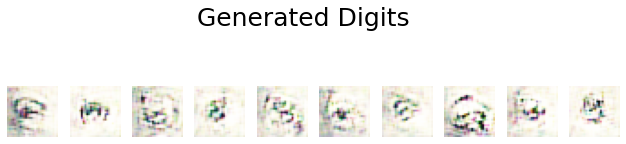

epoch:  481
discriminator loss:  0.4406493306159973
generator loss:  1.9672752618789673
--------------------------------------------------------------------------------
epoch:  482
discriminator loss:  0.4715564250946045
generator loss:  0.6225429773330688
--------------------------------------------------------------------------------
epoch:  483
discriminator loss:  0.5911074280738831
generator loss:  2.143449306488037
--------------------------------------------------------------------------------
epoch:  484
discriminator loss:  0.5198546648025513
generator loss:  0.8515629768371582
--------------------------------------------------------------------------------
epoch:  485
discriminator loss:  0.5071373581886292
generator loss:  1.5581189393997192
--------------------------------------------------------------------------------


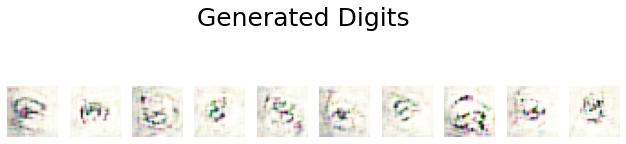

epoch:  486
discriminator loss:  0.4449867010116577
generator loss:  1.504921555519104
--------------------------------------------------------------------------------
epoch:  487
discriminator loss:  0.42221876978874207
generator loss:  1.2956596612930298
--------------------------------------------------------------------------------
epoch:  488
discriminator loss:  0.429937481880188
generator loss:  1.6079585552215576
--------------------------------------------------------------------------------
epoch:  489
discriminator loss:  0.4320192337036133
generator loss:  1.1960698366165161
--------------------------------------------------------------------------------
epoch:  490
discriminator loss:  0.4332646131515503
generator loss:  1.7756092548370361
--------------------------------------------------------------------------------


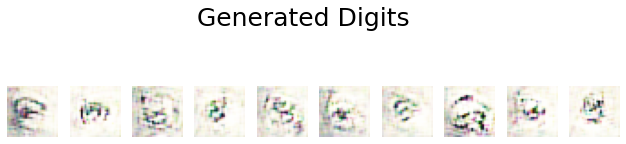

epoch:  491
discriminator loss:  0.4495057165622711
generator loss:  0.9136945605278015
--------------------------------------------------------------------------------
epoch:  492
discriminator loss:  0.4744453430175781
generator loss:  2.2817118167877197
--------------------------------------------------------------------------------
epoch:  493
discriminator loss:  0.49890726804733276
generator loss:  0.5230380892753601
--------------------------------------------------------------------------------
epoch:  494
discriminator loss:  0.6391190886497498
generator loss:  1.953263759613037
--------------------------------------------------------------------------------
epoch:  495
discriminator loss:  0.47397369146347046
generator loss:  1.3616819381713867
--------------------------------------------------------------------------------


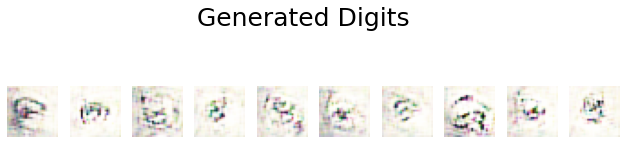

epoch:  496
discriminator loss:  0.4359362721443176
generator loss:  1.3008860349655151
--------------------------------------------------------------------------------
epoch:  497
discriminator loss:  0.4282609224319458
generator loss:  1.75490140914917
--------------------------------------------------------------------------------
epoch:  498
discriminator loss:  0.44601601362228394
generator loss:  1.0202326774597168
--------------------------------------------------------------------------------
epoch:  499
discriminator loss:  0.45469897985458374
generator loss:  1.968674898147583
--------------------------------------------------------------------------------


In [26]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        input_gen = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_data = generator.predict(input_gen)
        
        real_data = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
        real_data = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
        real_data = real_data.reshape((batch_size, 28, 28, 3))
        
        input_disc = np.concatenate((real_data, fake_data))

        label_disc = np.zeros(2*batch_size)
        label_disc[:batch_size] = 0.9
        label_disc[batch_size:] = 0.1
        loss_disc = discriminator.train_on_batch(input_disc, label_disc)

        label_gen = np.ones(batch_size)
        loss_gen = gan.train_on_batch(input_gen, label_gen)

    print("epoch: ", epoch)
    print("discriminator loss: ", loss_disc)
    print("generator loss: ", loss_gen)
    print("-"*80)
    
    if epoch % 5 == 0:
        show_generated_alphabets("Generated Digits", epoch)